In [1]:
# checking os
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))



Linux-6.6.56+-x86_64-with-glibc2.35


In [2]:
# checking that is t4 gpu is connected

import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;    
print("Tensorflow version " + tf.__version__)


Thu Mar  6 13:37:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
#Dataset path

PROJECT_DIR = '/kaggle/input/hockey-fight-dataset-splitted-dataset'

In [6]:
#Data agumentation on pre processsing data
import cv2
import os
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 224
ColorChannels = 3

# Albumentations Augmentation Pipeline
transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(blur_limit=3, p=0.3),
    A.MotionBlur(blur_limit=3, p=0.2),
    A.CLAHE(p=0.2),
])

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    count = 0
    ImageFrames = []

    while vidcap.isOpened():
        ID = vidcap.get(1)  # Frame ID
        success, image = vidcap.read()

        if success:
            # Skipping frames to avoid duplications
            if ID % 7 == 0:
                # Apply Albumentations augmentation
                augmented = transform(image=image)["image"]

                # Convert BGR to RGB before resizing
                rgb_img = cv2.cvtColor(augmented, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))

                ImageFrames.append(resized)
                count += 1
        else:
            break

    vidcap.release()
    return ImageFrames


In [7]:
# dataset path cross checking
import os
VideoDataDir = "/kaggle/input/hockey-fight-dataset-splitted-dataset"
print(os.listdir(VideoDataDir))  # List all folders inside the dataset

['hockey fight']


In [11]:
%%time
from tqdm import tqdm

VideoDataDir = PROJECT_DIR + '/hockey fight'
print('we have \n{} Violent videos \n{} non violent videos'.format(
              len(os.listdir(VideoDataDir + '/violent')), 
              len(os.listdir(VideoDataDir + '/non violent'))))

X_original = []
y_original = []


CLASSES = ["non violent", "violent"]


for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:500])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

we have 
500 Violent videos 
500 non violent videos


100%|██████████| 500/500 [00:18<00:00, 26.87it/s]

CPU times: user 44.6 s, sys: 20.2 s, total: 1min 4s
Wall time: 36 s


In [12]:
#Data Flattening and Reshaping
#cell is converting image data into 1D feature vectors

import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)

# checking no of sample
len(X_original)

6007

In [13]:
# Dataset Splitting using Stratified Shuffle Split
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

In [14]:
!pip install imutils
clear_output()

In [16]:
# importing libraires
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

In [17]:
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, LSTM, TimeDistributed, GlobalAveragePooling2D, Reshape
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime

In [18]:
#Hyperparameter Initialization

IMG_SIZE = 224
ColorChannels = 3
epochs = 50
patience = 3
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 4
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8
kernel_regularizer = regularizers.l2(0.0001)

In [19]:
# Load Model with LSTM
def load_model():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, x.shape[-1]))(x)  # Reshape to 3D tensor for LSTM
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = load_model()

<ipython-input-19-c7926920566e>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,606,529 (9.94 MB)

 Trainable params: 348,545 (1.33 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
checkpoint_filepath = './best_model.weights.h5'  # Correct file name ✅

# Learning Rate Scheduler
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.999:
            print("\nLimits Reached, cancelling training!")
            self.model.stop_training = True

end_callback = myCallback()
lr_callback = LearningRateScheduler(lrfn, verbose=True)
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True, verbose=1, min_delta=0.00075)
reduce_lr = ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, reduce_lr]



In [25]:

# Training the Model
print('Training Model...')
history = model.fit(X_train_nn, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_nn, y_test), callbacks=callbacks)

print('\nRestoring best weights for MobileNetV2 + LSTM')
model.load_weights(checkpoint_filepath)

Training Model...

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/50
1047/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5478 - loss: 0.6889
Epoch 1: val_loss improved from inf to 0.55374, saving model to ./best_model.weights.h5
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - accuracy: 0.5483 - loss: 0.6887 - val_accuracy: 0.8691 - val_loss: 0.5537 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.8000000000000004e-05.
Epoch 2/50
1050/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8275 - loss: 0.5090
Epoch 2: val_loss improved from 0.55374 to 0.32778, saving model to ./best_model.weights.h5
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.8275 - loss: 0.5089 - val_accuracy: 0.8991 - val_loss: 0.3278 - learning_rate: 1.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 2.6000000000000002e-05.
Epoch 3/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8805 - loss: 0.3587
Epoch 3: va

In [26]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30) 

------------------------------------------------------------------------------------------
Best Epochs:  22
Accuracy on train: 0.9526641368865967 	Loss on train: 0.14642678201198578
Accuracy on test: 0.941209077835083 	Loss on test: 0.16338203847408295


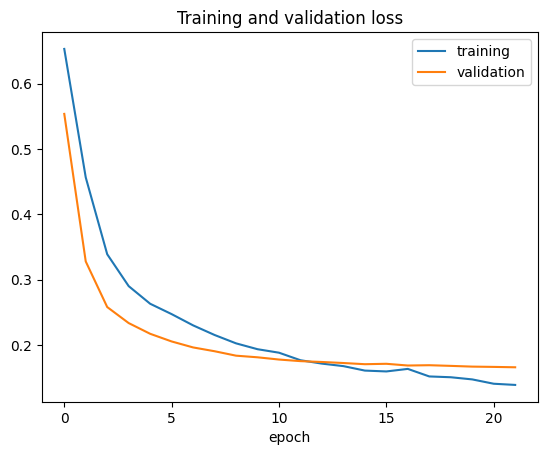

<Figure size 640x480 with 0 Axes>

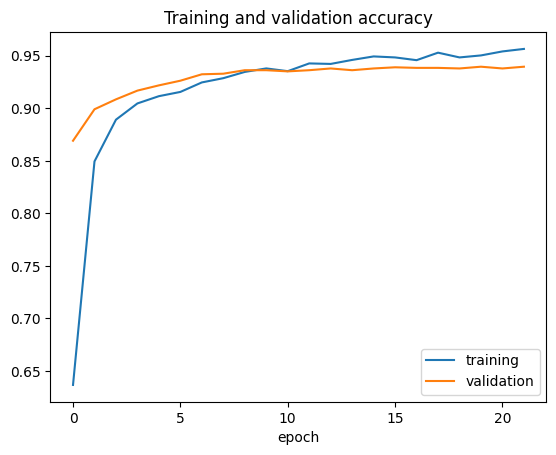

------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [27]:
model_summary(model, history)

In [28]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step


> Correct Predictions: 1697
> Wrong Predictions: 106


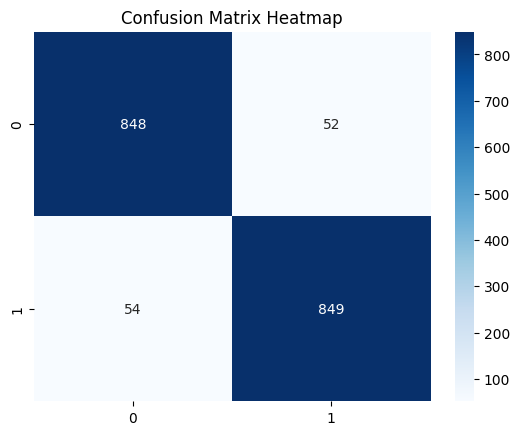

              precision    recall  f1-score   support

 NonViolence       0.94      0.94      0.94       900
    Violence       0.94      0.94      0.94       903

    accuracy                           0.94      1803
   macro avg       0.94      0.94      0.94      1803
weighted avg       0.94      0.94      0.94      1803



In [39]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay, accuracy_score, classification_report, confusion_matrix

# Confusion Matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = int((corr_pred[0][1] + corr_pred[1][0]))
print('> Wrong Predictions:', n_wrongs)

# Heatmap for Confusion Matrix
sns.heatmap(corr_pred, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Heatmap")
plt.show()

# Classification Report
print(metrics.classification_report(y_test, preds, target_names=["NonViolence", "Violence"]))




57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


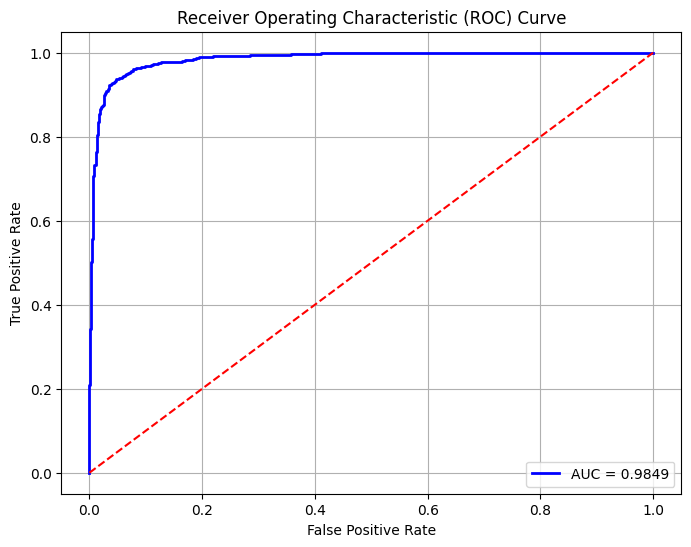

AUC Score: 0.9849255567860218


In [40]:
y_pred_prob = model.predict(X_test_nn)
y_pred_binary = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)  # Use y_pred_prob (probabilities) here
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

print("AUC Score:", roc_auc)



In [41]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, preds)
print("MCC Score:", mcc)


MCC Score: 0.8824204719823686


In [42]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test, preds)
print("Cohen's Kappa Score:", kappa)


Cohen's Kappa Score: 0.8824183004123277


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


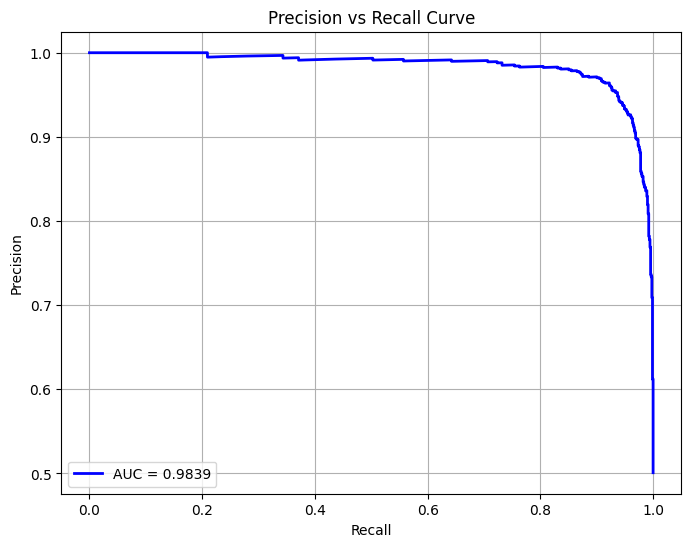

Precision-Recall AUC Score: 0.9839169851154229


In [43]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Predict Probabilities
y_pred_prob = model.predict(X_test_nn)

# Calculate Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='AUC = %0.4f' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print("Precision-Recall AUC Score:", pr_auc)


In [44]:
args_model = "modelnew.h5"
model.save(args_model)